# Background Detail Likert Scale - Story 2

This notebook assesses inter-annotator agreement for the background detail/information amount score. 
It imports JSON files to perform a number of statistical tests to assess inter-annotator agreement. 

##### Imports and packages

In [1]:
# Imports and Packages:

import json # json library
import os # for list directories 

from collections import Counter # counter library
import re # regex

import numpy as np 
import math
import matplotlib.pyplot as plt

import itertools
from itertools import permutations # library to print permutations
from itertools import combinations # library to print combinations

import sklearn # sklearn for inter-annotation kappa scores
from sklearn.metrics import cohen_kappa_score
import statsmodels
from statsmodels.stats.inter_rater import fleiss_kappa

import krippendorff #import for Fleiss Kappa inter-annotator agreement for more than 2 annotators

import scipy.stats
from scipy.stats import mode 
from scipy.stats import zscore # normalise data
from scipy.stats import mannwhitneyu # for Mann-Whitney U test
from scipy.stats import ttest_ind # independent t-test
from scipy.stats import spearmanr # spearmans rank
from scipy.stats import pearsonr # pearson's r


##### Import JSON data

In [2]:
# Import JSON data from Prolific Study

path_to_jsonFiles = "Annotations_Prolific/Background_Detail_LikertScale_Story2/Processed_Data" # This is the folder with the json data files
corpus = {} # init a dict to hold each json data file
participantNum = 1 # init a participant num counter

for file in sorted(os.listdir(path_to_jsonFiles)):
    if file.endswith('.json'): # check that the file has a json extension (to circumvent hidden .DS_store files)
        full_file_name = "%s/%s" % (path_to_jsonFiles, file)
        with open(full_file_name, 'r') as fi:
            storyName = "participant" + str(participantNum)
            story_data = json.load(fi)
            corpus[storyName] = story_data
        participantNum += 1
    
# all_stories holds all the json data files, with key "storyN" and value is the read in json file


In [3]:
# check that the data was read in correctly
# corpus['participant1']


##### Get annotator pair combinations as pairs of names in a list

In [4]:
# Combinations of annotators:
# Function to get the combinations of all participants

def get_combinations_of_annotators(all_annotation_data):
    """
    Takes: a dict containing all annotation data - this is the input of reading in all json files,
            as is done above.
    Returns: a list of tuples containing pairs of strings that indicate annotators. In other words, a list of 
            annotator pairs.
    """
    annotators = [] # init a list to store annotators
    annotator_pairs = [] # init a list to store all combination pairs
    
    for annotator, annotation_data in all_annotation_data.items():
        annotators.append(annotator)
     
    combs = itertools.combinations(annotators, 2) # get annotator combinations in sets of two
    
    for ann in list(combs):
        annotator_pairs.append(ann)
    
    return annotator_pairs


In [5]:
# Get all annotator combinations
combinations_all_participants = get_combinations_of_annotators(corpus)


In [6]:
#print(combinations_all_participants)

In [7]:
# get a list of all values per participant, put in a dict "background_values"

background_values = {}

for participant, story_info in corpus.items():
    values = [] # init values list
    for page, page_info in story_info.items():
        for panel, panel_info in page_info.items():
            background_info = panel_info["background/setting"]
            value = float(background_info["information_amount"])
            values.append(value)
    
    background_values[participant] = values
    
#background_values    
    

In [8]:
# Get raw background values value per panel 

raw_value_per_panel = {}

for participant, values in background_values.items():
    panelNum = 0
    for val in values:
        panelName = panelNum + 1
        if raw_value_per_panel.get(panelName) == None:
            raw_value_per_panel[panelName] = []
        if raw_value_per_panel.get(panelName) != None:
            raw_value_per_panel[panelName].append(val)
        panelNum += 1



##### Store the annotation values per annotator in a dictionary and list of lists for easier analysis

In [9]:
# put all sets of background values into a list of lists

list_of_lists_of_all_participant_values = []
for participant, values_list in background_values.items():
    #print(participant)
    #print(values_list)
    list_of_lists_of_all_participant_values.append(values_list)
    
print(len(list_of_lists_of_all_participant_values))


9


### Krippendorff's Alpha

##### Function to calculate Krippendorff's Alpha

In [10]:
# Krippendorff's Alpha - Inter-rater agreement measure

# Code from https://github.com/grrrr/krippendorff-alpha/blob/master/krippendorff_alpha.py

def nominal_metric(a, b):
    return a != b

def interval_metric(a, b):
    return (a-b)**2

def ratio_metric(a, b):
    return ((a-b)/(a+b))**2

def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Python implementation of Krippendorff's alpha -- inter-rater reliability
    (c)2011-17 Thomas Grill (http://grrrr.org)
    Python version >= 2.4 required

    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to 
    coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.


In [11]:
# no ordinal metric available in this function
#kalpha = krippendorff_alpha(list_of_lists_of_all_participant_values, interval_metric) # get the k alpha for each ind agent
#print(kalpha)


##### Krippendorff's Alpha result for all-against-all annotators, using the Krippendorff 0.7.0 Python package

In [13]:
# Better measure with ordinal weighting
from krippendorff.krippendorff import alpha
print(krippendorff.alpha(list_of_lists_of_all_participant_values, level_of_measurement="ordinal"))


0.3603727261740116


##### Krippendorff's Alpha results for all individual annotator pairs

In [14]:
KA_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    KA_value = krippendorff_alpha([background_values[ann1], background_values[ann2]])
    KA_values.append(KA_value)
    
print("Pairwise KA values: \n")
print(KA_values)
print("\n")
print("mean: ", np.mean(KA_values))
print("std: ", np.std(KA_values))

#print(background_values[ann1])

Pairwise KA values: 

[0.36398104265402853, -0.10174201132841709, -0.5204613095238093, 0.38058489033306264, 0.21640316205533605, 0.4077669902912622, -0.09232558139534897, 0.3914044512663085, 0.3772554605887939, -0.07447045707915279, 0.7579822406952579, 0.6985493384345608, 0.08955223880597019, 0.29575820469581005, 0.8097147950089126, 0.3482317531978931, 0.5240819723291376, 0.6625909752547308, -0.32391482391482374, 0.660046610598845, 0.3612565445026179, 0.05559465165376487, 0.19736842105263164, -0.5733079453003289, 0.003666666666666707, 0.031746031746031744, 0.8106570098292809, 0.0409950248756219, 0.5206555904804671, 0.7675998012257744, -0.07017543859649122, 0.41590341382181517, 0.7305116146501354, -0.3486279302299744, 0.014141414141414232, 0.2711463385780195]


mean:  0.252781143112939
std:  0.3688679681811318


### Per-panel analysis of annotator agreement

##### Get all annotators raw values and z-score normalised values per panel 

In [15]:
# z-score normalisation - normalise the raw background values for STUDY 2

zscore_values = {}

for participant, values in background_values.items():
    int_values =  [float(i) for i in values]
    normalised_values = zscore(int_values)
    
    zscore_values[participant] = list(normalised_values)
    

In [16]:
#zscore_values['participant9']

In [17]:
# Get each zscore value per panel 

zscores_per_panel = {}

for participant, values in zscore_values.items():
    panelNum = 0
    for val in values:
        panelName = panelNum + 1
        if zscores_per_panel.get(panelName) == None:
            zscores_per_panel[panelName] = []
        if zscores_per_panel.get(panelName) != None:
            zscores_per_panel[panelName].append(val)
        panelNum += 1


In [18]:
#zscores_per_panel[1]

In [19]:
# mean z_score per panel

normalised_mean_per_panel = {}

for panelNum, scores in zscores_per_panel.items():
    normalised_mean_per_panel[panelNum] = np.mean(scores)


In [20]:
# just means in a list without panel
ordinal_story2_just_means_normalised = []

for panel, mean in normalised_mean_per_panel.items():
    ordinal_story2_just_means_normalised.append(mean)
    

In [21]:
ordinal_story2_just_means_normalised

[0.5847983189691979,
 1.9542141958643993,
 -0.9593231832459657,
 -0.5023332660236659,
 -0.12450824333660797,
 -0.44455615366971113,
 -1.1490936954365556,
 -0.7079208637964751,
 -0.20977029494202576,
 0.20179618079948441,
 -0.4853119168944217,
 -0.49478850584628276,
 -0.17704174388966487,
 1.0591898867961886,
 0.8062489027752763,
 0.3741251901513597,
 1.06467486975479,
 0.9712095448312671,
 0.4913244018425037,
 0.033521450442119946,
 0.7831992039727512,
 0.025666887954676032,
 -0.31873282252545726,
 -0.06269136581542417,
 0.542743658110587,
 0.7707840809735247,
 -0.7708515686892761,
 -0.9593231832459657,
 -0.8285738601457723,
 -0.8285738601457723,
 -0.6401022455890826]

In [22]:
# STD for the z_score of each panel

STD_per_panel = {}

for panelNum, scores in zscores_per_panel.items():
    STD_per_panel[panelNum] = np.std(scores)


In [23]:
STD_per_panel

{1: 0.5984478277751945,
 2: 0.8999687485946114,
 3: 0.35326172866300914,
 4: 0.6141670842349617,
 5: 0.642089865028483,
 6: 0.6875371560742244,
 7: 0.594127396479756,
 8: 0.7560588082098266,
 9: 0.7091160293130936,
 10: 0.6549152556668013,
 11: 0.31826638268171287,
 12: 0.3183962382294805,
 13: 0.3704865381543799,
 14: 0.8385697837820697,
 15: 0.5628807856206959,
 16: 0.9549612140296636,
 17: 0.6732930374492092,
 18: 0.17470257448811158,
 19: 0.5816071586921938,
 20: 0.7008848594194992,
 21: 0.7067547584810457,
 22: 0.7002532053170336,
 23: 0.7316556582460844,
 24: 0.654468637758958,
 25: 0.8309905726479921,
 26: 0.9535090802756147,
 27: 0.7512139941407603,
 28: 0.35326172866300914,
 29: 0.650447131412082,
 30: 0.650447131412082,
 31: 0.9018453386048894}

In [24]:
# just stds in a list without panel

ordinal_story2_just_stds_normalised = []

for panel, std in STD_per_panel.items():
    ordinal_story2_just_stds_normalised.append(std)
    

In [25]:
ordinal_story2_just_stds_normalised

[0.5984478277751945,
 0.8999687485946114,
 0.35326172866300914,
 0.6141670842349617,
 0.642089865028483,
 0.6875371560742244,
 0.594127396479756,
 0.7560588082098266,
 0.7091160293130936,
 0.6549152556668013,
 0.31826638268171287,
 0.3183962382294805,
 0.3704865381543799,
 0.8385697837820697,
 0.5628807856206959,
 0.9549612140296636,
 0.6732930374492092,
 0.17470257448811158,
 0.5816071586921938,
 0.7008848594194992,
 0.7067547584810457,
 0.7002532053170336,
 0.7316556582460844,
 0.654468637758958,
 0.8309905726479921,
 0.9535090802756147,
 0.7512139941407603,
 0.35326172866300914,
 0.650447131412082,
 0.650447131412082,
 0.9018453386048894]

##### Sort by most agreed to least agreed panel

In [27]:
# get five highest and five lowest:
        
import operator
sorted_STD_per_panel = sorted(STD_per_panel.items(), key=operator.itemgetter(1))

print(sorted_STD_per_panel)


[(18, 0.17470257448811158), (11, 0.31826638268171287), (12, 0.3183962382294805), (3, 0.35326172866300914), (28, 0.35326172866300914), (13, 0.3704865381543799), (15, 0.5628807856206959), (19, 0.5816071586921938), (7, 0.594127396479756), (1, 0.5984478277751945), (4, 0.6141670842349617), (5, 0.642089865028483), (29, 0.650447131412082), (30, 0.650447131412082), (24, 0.654468637758958), (10, 0.6549152556668013), (17, 0.6732930374492092), (6, 0.6875371560742244), (22, 0.7002532053170336), (20, 0.7008848594194992), (21, 0.7067547584810457), (9, 0.7091160293130936), (23, 0.7316556582460844), (27, 0.7512139941407603), (8, 0.7560588082098266), (25, 0.8309905726479921), (14, 0.8385697837820697), (2, 0.8999687485946114), (31, 0.9018453386048894), (26, 0.9535090802756147), (16, 0.9549612140296636)]


In [28]:
raw_value_per_panel

{1: [2.0, 3.0, 4.0, 3.0, 4.0, 4.0, 1.0, 5.0, 3.0],
 2: [4.0, 4.0, 5.0, 4.0, 5.0, 5.0, 3.0, 5.0, 5.0],
 3: [1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 4: [2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0],
 5: [2.0, 2.0, 3.0, 2.0, 3.0, 2.0, 1.0, 4.0, 2.0],
 6: [1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 5.0, 2.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0],
 8: [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 5.0, 2.0],
 9: [1.0, 2.0, 2.0, 4.0, 2.0, 1.0, 2.0, 2.0, 2.0],
 10: [2.0, 2.0, 4.0, 4.0, 3.0, 1.0, 1.0, 5.0, 2.0],
 11: [1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0, 3.0, 1.0],
 12: [1.0, 2.0, 3.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0],
 13: [1.0, 2.0, 4.0, 3.0, 2.0, 2.0, 1.0, 4.0, 2.0],
 14: [2.0, 3.0, 5.0, 4.0, 5.0, 5.0, 1.0, 4.0, 5.0],
 15: [2.0, 3.0, 5.0, 4.0, 4.0, 4.0, 1.0, 4.0, 4.0],
 16: [1.0, 4.0, 4.0, 4.0, 2.0, 4.0, 1.0, 2.0, 4.0],
 17: [2.0, 4.0, 5.0, 4.0, 4.0, 5.0, 1.0, 5.0, 4.0],
 18: [2.0, 3.0, 5.0, 4.0, 4.0, 4.0, 2.0, 5.0, 3.0],
 19: [2.0, 2.0, 5.0, 4.0, 3.0, 4.0, 1.0, 5.0, 2.0],
 20: [2.0, 2.0, 5.0, 

In [29]:
# Mean for the raw score of each panel

mean_per_panel = {}

for panelNum, scores in raw_value_per_panel.items():
    mean_per_panel[panelNum] = np.mean(scores)
    

In [30]:
mean_per_panel

{1: 3.2222222222222223,
 2: 4.444444444444445,
 3: 1.2222222222222223,
 4: 1.7777777777777777,
 5: 2.3333333333333335,
 6: 2.0,
 7: 1.1111111111111112,
 8: 1.6666666666666667,
 9: 2.0,
 10: 2.6666666666666665,
 11: 1.8888888888888888,
 12: 1.8888888888888888,
 13: 2.3333333333333335,
 14: 3.7777777777777777,
 15: 3.4444444444444446,
 16: 2.888888888888889,
 17: 3.7777777777777777,
 18: 3.5555555555555554,
 19: 3.111111111111111,
 20: 2.5555555555555554,
 21: 3.4444444444444446,
 22: 2.5555555555555554,
 23: 2.111111111111111,
 24: 2.4444444444444446,
 25: 3.111111111111111,
 26: 3.111111111111111,
 27: 1.3333333333333333,
 28: 1.2222222222222223,
 29: 1.3333333333333333,
 30: 1.3333333333333333,
 31: 1.4444444444444444}

In [31]:
# just means in a list without panel

ordinal_story2_just_means = []

for panel, mean in mean_per_panel.items():
    ordinal_story2_just_means.append(mean)


In [32]:
ordinal_story2_just_means

[3.2222222222222223,
 4.444444444444445,
 1.2222222222222223,
 1.7777777777777777,
 2.3333333333333335,
 2.0,
 1.1111111111111112,
 1.6666666666666667,
 2.0,
 2.6666666666666665,
 1.8888888888888888,
 1.8888888888888888,
 2.3333333333333335,
 3.7777777777777777,
 3.4444444444444446,
 2.888888888888889,
 3.7777777777777777,
 3.5555555555555554,
 3.111111111111111,
 2.5555555555555554,
 3.4444444444444446,
 2.5555555555555554,
 2.111111111111111,
 2.4444444444444446,
 3.111111111111111,
 3.111111111111111,
 1.3333333333333333,
 1.2222222222222223,
 1.3333333333333333,
 1.3333333333333333,
 1.4444444444444444]

## Pearson's r and Spearman's rank between annotator pairs

##### Calculate Spearman's rank between each annotator pair

In [33]:
# Spearman's rank function 

def get_spearmans_rank(values_Ann1, values_Ann2):
    """
    Takes: two lists of values
    Returns: nothing, but prints the the p value and states whether the null hypothesis was rejected.
    """
    # compare samples
    coef, p = spearmanr(values_Ann1, values_Ann2)
    print('%.3f' % coef)
    # interpret the significance
    alpha = 0.01
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
    return coef, p


In [34]:
# Calculate Spearman's r between all combinations of annotators

corr = 0
not_corr = 0

spearmans_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    print(ann1 + " and " + ann2 + ":")
    spearmans_value, p = get_spearmans_rank(background_values[ann1], background_values[ann2])
    if p > 0.01:
        corr +=1
    if p < 0.01:
        not_corr +=1
    spearmans_values.append(spearmans_value)
print("********************")
print(spearmans_values)
print("correlated: ", corr)
print("not correlated: ", not_corr)
print("mean: ", np.mean(spearmans_values))
print("std: ", np.std(spearmans_values))


participant1 and participant2:
0.634
Samples are correlated (reject H0) p=0.000
participant1 and participant3:
0.541
Samples are correlated (reject H0) p=0.002
participant1 and participant4:
0.036
Samples are uncorrelated (fail to reject H0) p=0.846
participant1 and participant5:
0.731
Samples are correlated (reject H0) p=0.000
participant1 and participant6:
0.578
Samples are correlated (reject H0) p=0.001
participant1 and participant7:
0.186
Samples are uncorrelated (fail to reject H0) p=0.317
participant1 and participant8:
0.588
Samples are correlated (reject H0) p=0.001
participant1 and participant9:
0.599
Samples are correlated (reject H0) p=0.000
participant2 and participant3:
0.704
Samples are correlated (reject H0) p=0.000
participant2 and participant4:
0.226
Samples are uncorrelated (fail to reject H0) p=0.222
participant2 and participant5:
0.849
Samples are correlated (reject H0) p=0.000
participant2 and participant6:
0.806
Samples are correlated (reject H0) p=0.000
participan

In [ ]:
print(np.mean(spearmans_values))

##### Calculate Pearson's r scores between each annotator pair

In [35]:
# Pearson's r function 

def get_pearsonsr(values_Ann1, values_Ann2):
    """
    Takes: two lists of values
    Returns: nothing, but prints the the p value and states whether the null hypothesis was rejected.
    """
    
    # compare samples
    coef, p = pearsonr(values_Ann1, values_Ann2)
    print('Pearsons correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.01
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
    
    return coef, p


In [36]:
corr = 0
not_corr = 0

pearsons_values = []
for participant_pair in combinations_all_participants:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    pearsons_value, p = get_pearsonsr(background_values[ann1], background_values[ann2])
    if p > 0.01:
        corr +=1
    if p < 0.01:
        not_corr +=1
    pearsons_values.append(pearsons_value)
    
print(pearsons_values)
print("correlated: ", corr)
print("not correlated: ", not_corr)
print("mean: ", np.mean(pearsons_values))
print("std: ", np.std(pearsons_values))


Pearsons correlation coefficient: 0.618
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.503
Samples are correlated (reject H0) p=0.004
Pearsons correlation coefficient: 0.094
Samples are uncorrelated (fail to reject H0) p=0.616
Pearsons correlation coefficient: 0.735
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.557
Samples are correlated (reject H0) p=0.001
Pearsons correlation coefficient: 0.424
Samples are uncorrelated (fail to reject H0) p=0.017
Pearsons correlation coefficient: 0.552
Samples are correlated (reject H0) p=0.001
Pearsons correlation coefficient: 0.647
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.699
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.252
Samples are uncorrelated (fail to reject H0) p=0.172
Pearsons correlation coefficient: 0.796
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.779
Samples are corre

In [37]:
# get all the values per panel/segmentation
def get_values_per_panel(corpus_dict, scores):
    """
    Takes: a corpus dict
    Returns: a dict with a list of values of all annotators per panel in the story, setup as a 
        dict of pages, with the values panels, with the values of lists of floats. 
    """
    
    all_values_per_panel = {} # init dict
    
    #print(zscores)

    for participant, story_info in corpus_dict.items():
        value_index = 0 # init an index to get the correct zscore from the array
        for page, page_info in story_info.items():
            if all_values_per_panel.get(page) == None: # if this page has not been initialized in the final dict,
                all_values_per_panel[page] = {} # create it here
            for panel, panel_info in page_info.items():
                if all_values_per_panel[page].get(panel) == None: # if this panel has not been initialized, 
                    all_values_per_panel[page][panel] = [] # create it here
                background_detail = float(panel_info["background/setting"]["information_amount"]) # get value
                score_value = scores[participant][value_index]
                all_values_per_panel[page][panel].append(score_value)
                value_index += 1
                
    #print(all_values_per_panel)
                
    return all_values_per_panel
    
   


In [38]:
values_per_panel = get_values_per_panel(corpus, background_values)

In [39]:
values_per_panel

{'page1': {'panel1': [2.0, 3.0, 4.0, 3.0, 4.0, 4.0, 1.0, 5.0, 3.0],
  'panel2': [4.0, 4.0, 5.0, 4.0, 5.0, 5.0, 3.0, 5.0, 5.0],
  'panel3': [1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0]},
 'page2': {'panel1': [2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0],
  'panel2': [2.0, 2.0, 3.0, 2.0, 3.0, 2.0, 1.0, 4.0, 2.0],
  'panel3': [1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 5.0, 2.0],
  'panel4': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0],
  'panel5': [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 5.0, 2.0],
  'panel6': [1.0, 2.0, 2.0, 4.0, 2.0, 1.0, 2.0, 2.0, 2.0],
  'panel7': [2.0, 2.0, 4.0, 4.0, 3.0, 1.0, 1.0, 5.0, 2.0]},
 'page3': {'panel1': [1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 1.0, 3.0, 1.0],
  'panel2': [1.0, 2.0, 3.0, 3.0, 1.0, 2.0, 1.0, 3.0, 1.0],
  'panel3': [1.0, 2.0, 4.0, 3.0, 2.0, 2.0, 1.0, 4.0, 2.0],
  'panel4': [2.0, 3.0, 5.0, 4.0, 5.0, 5.0, 1.0, 4.0, 5.0],
  'panel5': [2.0, 3.0, 5.0, 4.0, 4.0, 4.0, 1.0, 4.0, 4.0],
  'panel6': [1.0, 4.0, 4.0, 4.0, 2.0, 4.0, 1.0, 2.0, 4.0],
  'panel7': [2.0, 4.0, 5.0,

In [40]:
# Visualise the results of each panel 

def boxplot_results_per_panel(results_per_panel):
    """
    Takes:
    Returns:
    """
    
    for page, panels in results_per_panel.items():
        #print(panels)
        for panel, values in panels.items():
            #print(values)
            
            fig1, ax1 = plt.subplots()
            ax1.set_title(page + panel)
            plt.ylim(0,5)
            ax1.boxplot(values)
            
            

/var/folders/rd/ytgbsj2n3czfz5nsrrgbfjsh0000gn/T/ipykernel_94121/2010021960.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, ax1 = plt.subplots()


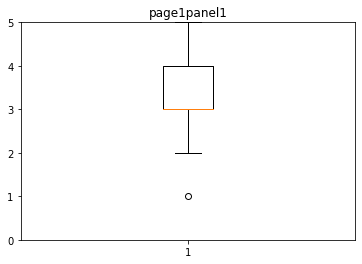

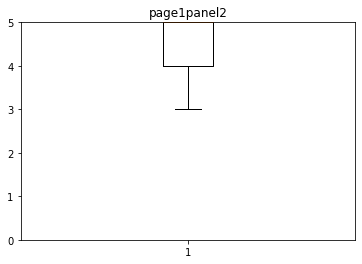

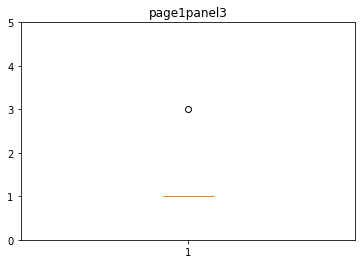

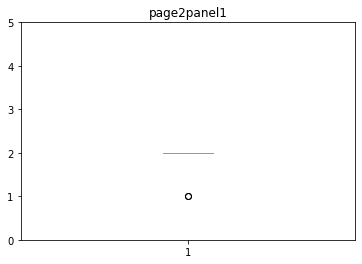

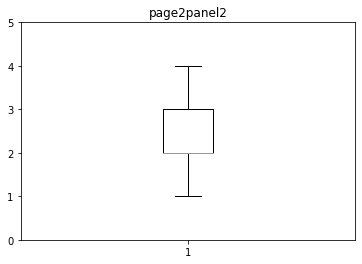

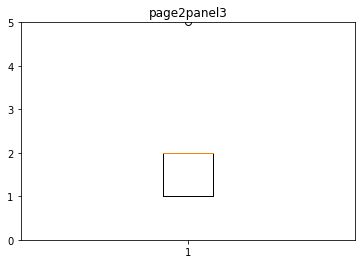

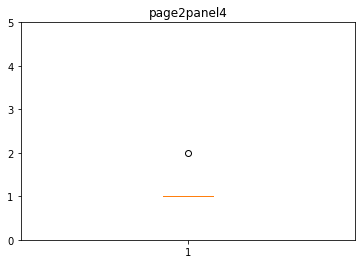

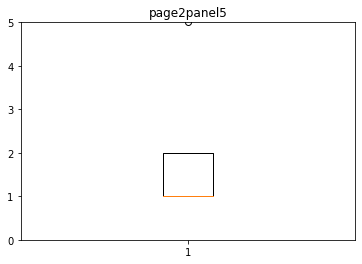

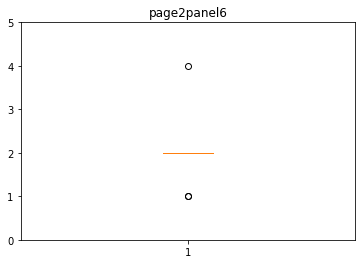

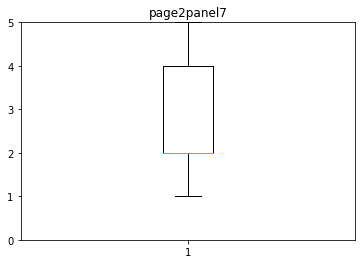

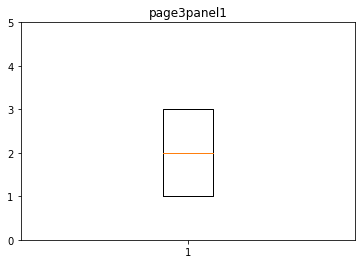

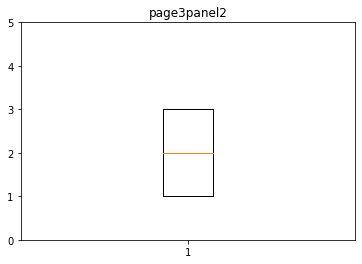

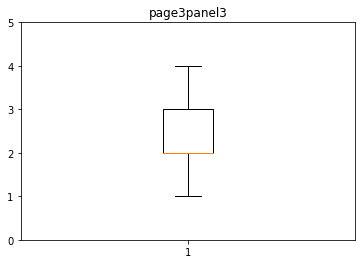

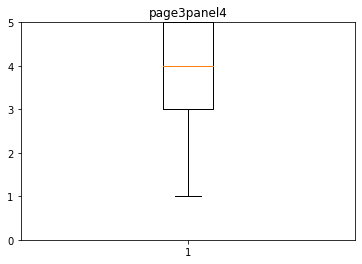

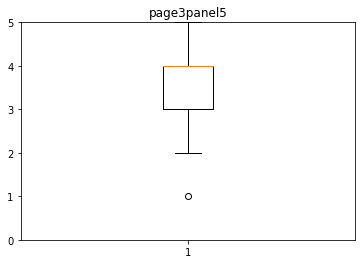

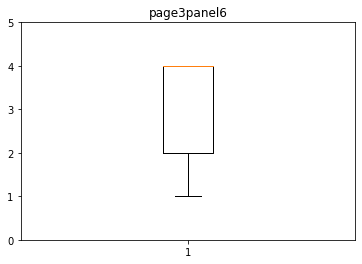

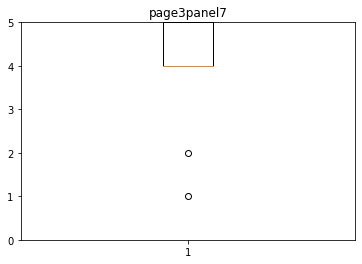

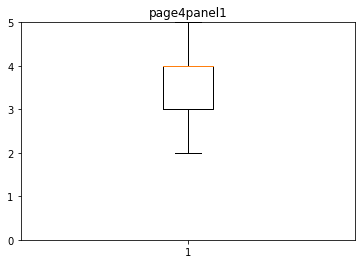

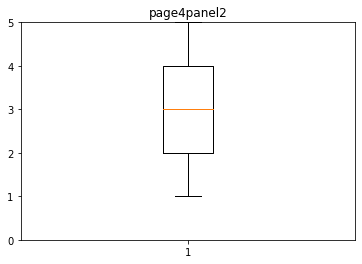

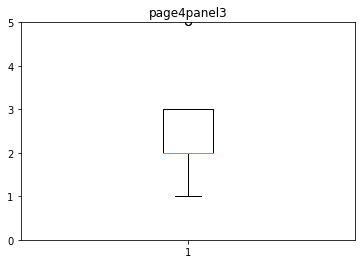

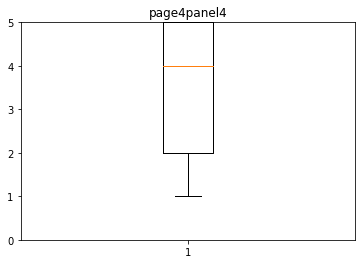

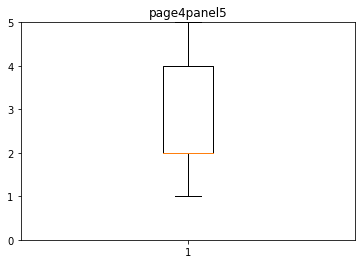

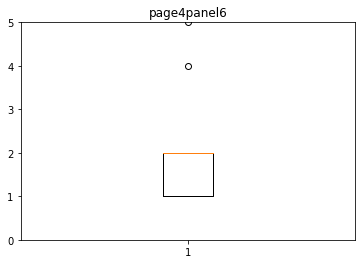

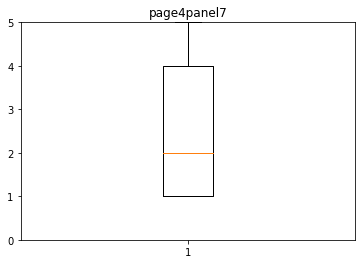

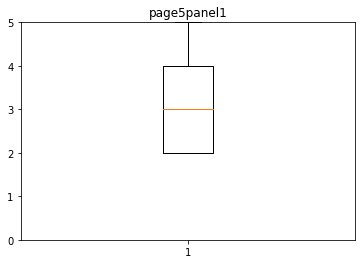

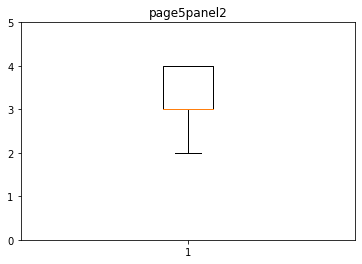

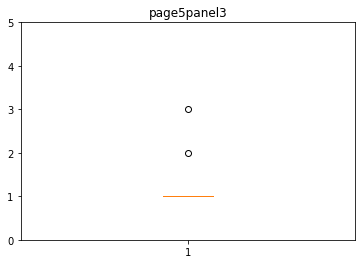

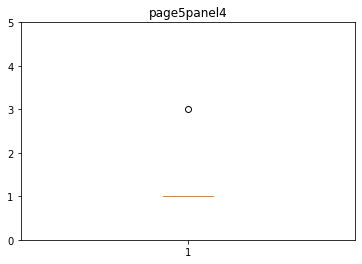

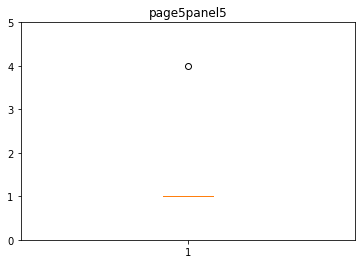

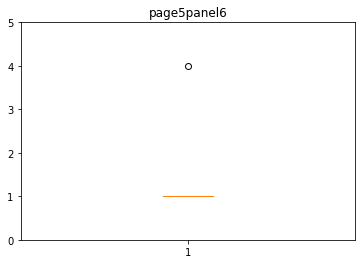

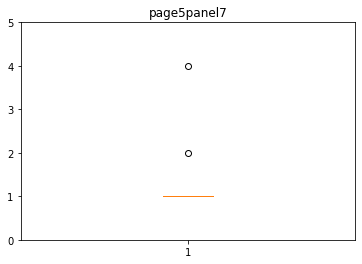

In [41]:
boxplot_results_per_panel(values_per_panel)

## Heatmaps: Annotator agreement and reliability

In [42]:
# Functions to create heatmap of annotator agreement:

In [43]:
# Additional utilities for plotting images
# from: https://shravan-kuchkula.github.io/nlp/document_similarity/#plot-a-heatmap-of-cosine-similarity-values

##############################
#  Module: utils.py
#  Author: Shravan Kuchkula
#  Date: 07/19/2019
##############################

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_heatmap(df_hm, xlabels, ylabels, title):
    """
    Given a dataframe containing similarity grid, plot the heatmap
    """
    sns.set(style="white")

    # Set up the matplotlib figure
    # (to enlarge the cells, increase the figure size)
    fig, ax = plt.subplots(figsize=(10, 10)) 

    # Generate a custom diverging colormap
    #sns.diverging_palette("coolwarm", as_cmap=True)

    #cmap = sns.color_palette("viridis", as_cmap=True)
    #sns.diverging_palette("coolwarm", as_cmap=True)
    #cmap = sns.diverging_palette("coolwarm")
    cmap = sns.diverging_palette(260, 10, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_hm, dtype = bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df_hm, mask=mask, cmap=cmap, center=0.5, xticklabels=xlabels,
                yticklabels=ylabels,
                square=True, linewidths=.5, fmt='.2f',
                annot=True, vmin=0, vmax=1, cbar_kws={"shrink": 0.75},
                cbar=True)  
    # NOTE: center is the center color value
    # NOTE: vmin and vmax are the color map interval
    
#     b, t = plt.ylim() # discover the values for bottom and top
#     b += 0.5 # Add 0.5 to the bottom
#     t -= 0.5 # Subtract 0.5 from the top
#     plt.ylim(b, t) # update the ylim(bottom, top) values

    # create xtick locations
    xtick_locations = []
    for i in range(len(xlabels)):
        xtick_locations.append(i+0.5)
    #print(xtick_locations)
    

    ax.set_title(title).set_fontsize(15) # change the title to reflect the type of score
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.set_xticks(xtick_locations)
    #ax.set_xticklabels(xlabels)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.show()
    


In [44]:
# Heat Map of Similarity between Annotators
# code from: https://shravan-kuchkula.github.io/nlp/document_similarity/#

def create_heatmap_between_annotators_for_one_story(story_combinations, 
                                                    similarity_scores, 
                                                    annotators_list,
                                                    title):
    

    # create dict with annotator name as the key and annotator index number from list as the value 
    annotator_to_idx = {annotator_name: i for i, annotator_name in enumerate(annotators_list)}
    #print(annotator_to_idx)
    
    # create a dataframe
    df = pd.DataFrame({'pairs': story_combinations, 'similarity': similarity_scores})
    #display(df.head())
    #display(df.tail())

    # initialize an empty dataframe grid
    df_hm = pd.DataFrame({'ind': range(len(annotators_list)), 'cols': range(len(annotators_list)), 'vals': pd.Series(np.zeros(len(annotators_list)))})

    # convert to a matrix
    df_hm = df_hm.pivot(index='ind', columns='cols')#.fillna(0)

    #print(df_hm)

    # make a copy
    df_temp = df.copy()

    # convert list of tuples into 2 lists
    list1 = []
    list2 = []
    for item1, item2 in df_temp.pairs:
        list1.append(item1)
        list2.append(item2)

    #print(list1)
    #print(list2)

    # add two columns to df_temp
    df_temp['col1'] = list1
    df_temp['col2'] = list2

    # drop the pair as it not needed
    df_temp.drop('pairs', axis=1, inplace=True)

    # extract annotator index so that you can construct annotator pairs 
    df_temp['col1'] = df_temp['col1'].apply(lambda x: annotator_to_idx[x])
    df_temp['col2'] = df_temp['col2'].apply(lambda x: annotator_to_idx[x])

    # create tuples (0, 1, similarity)
    df_temp['pairs'] = list(zip(df_temp.col1, df_temp.col2, round(df_temp.similarity, 2)))

    #display(df_temp)

    # to get lower diagonal, swap the rows and cols.
    for row, col, similarity in df_temp.pairs:
        df_hm.iloc[col, row] = similarity
    
    plot_heatmap(df_hm, annotators_list, annotators_list, title)


    


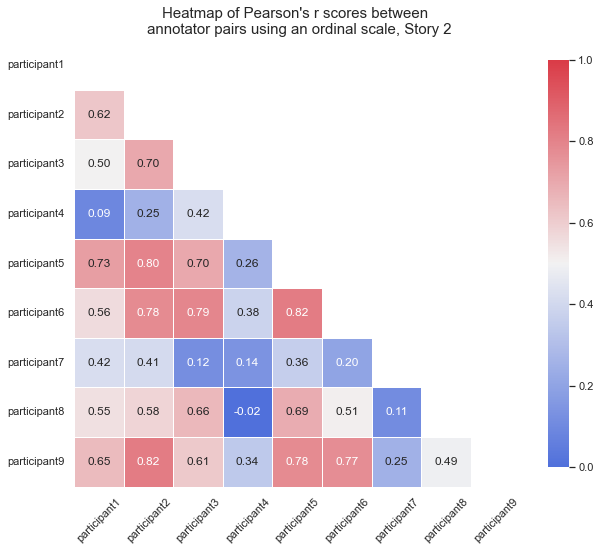

In [45]:
annotators = ["participant1",
              "participant2",
              "participant3",
              "participant4",
              "participant5",
              "participant6",
              "participant7",
              "participant8",
              "participant9"]

heatmap_panelIOU_pilot = create_heatmap_between_annotators_for_one_story(combinations_all_participants, 
                                                          pearsons_values,
                                                          annotators,
                                                          "Heatmap of Pearson's r scores between \n annotator pairs using an ordinal scale, Story 2")


In [46]:
background_values_drop = background_values
del background_values_drop["participant4"]
del background_values_drop["participant7"]
background_values_drop



{'participant1': [2.0,
  4.0,
  1.0,
  2.0,
  2.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  1.0,
  1.0,
  1.0,
  2.0,
  2.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  2.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'participant2': [3.0,
  4.0,
  1.0,
  2.0,
  2.0,
  2.0,
  1.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  3.0,
  3.0,
  4.0,
  4.0,
  3.0,
  2.0,
  2.0,
  3.0,
  2.0,
  1.0,
  2.0,
  3.0,
  4.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'participant3': [4.0,
  5.0,
  1.0,
  2.0,
  3.0,
  2.0,
  1.0,
  1.0,
  2.0,
  4.0,
  3.0,
  3.0,
  4.0,
  5.0,
  5.0,
  4.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  5.0,
  4.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'participant5': [4.0,
  5.0,
  1.0,
  1.0,
  3.0,
  2.0,
  1.0,
  1.0,
  2.0,
  3.0,
  2.0,
  1.0,
  2.0,
  5.0,
  4.0,
  2.0,
  4.0,
  4.0,
  3.0,
  2.0,
  4.0,
  2.0,
  1.0,
  1.0,
  4.0,
  3.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'participant6': [4.0,
  5.0,
  1.0,
  2.0,
  2.0,
  1.0,
  1.0,

In [47]:

combinations_annotators_drop = get_combinations_of_annotators(background_values_drop)


corr = 0
not_corr = 0

pearsons_values = []
for participant_pair in combinations_annotators_drop:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    pearsons_value, p = get_pearsonsr(background_values_drop[ann1], background_values_drop[ann2])
    if p > 0.01:
        corr +=1
    if p < 0.01:
        not_corr +=1
    pearsons_values.append(pearsons_value)
    
print(pearsons_values)
print("correlated: ", corr)
print("not correlated: ", not_corr)
print(np.mean(pearsons_values))



Pearsons correlation coefficient: 0.618
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.503
Samples are correlated (reject H0) p=0.004
Pearsons correlation coefficient: 0.735
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.557
Samples are correlated (reject H0) p=0.001
Pearsons correlation coefficient: 0.552
Samples are correlated (reject H0) p=0.001
Pearsons correlation coefficient: 0.647
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.699
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.796
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.779
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.581
Samples are correlated (reject H0) p=0.001
Pearsons correlation coefficient: 0.818
Samples are correlated (reject H0) p=0.000
Pearsons correlation coefficient: 0.701
Samples are correlated (reject H0) p=0.000
Pear